In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
from sklearn import preprocessing
import GPy
import GPyOpt
import copy
import time
import datetime

class Model:
    # Network Parameters
    # n_neurons, learning_rate, num_layers, rnn_type(RNN|BasicLSTM|LSTM|LSTM peelhole)
    # Control Parameters
    # risk_aversion - the margin added to the courtage that leads an buy or sell operation
    # learning_period - how many sequences model should learn before predicting next sequences
    # prediction_period - how many sequences the model should predict
    # max_repeats - how many times in maximum the model should learn
    # min_profit - what is the minimum profit in average during training phase, if the minimum is not reached, the model should not predict
    # gamma - what is the gamma used when preprocessing data
    
    step_profit_list = []
    mixed_domain = [{'name': 'n_neurons', 'type': 'discrete', 'domain': tuple(range(20,160,20))},
          {'name': 'learning_rate', 'type': 'discrete', 'domain': (0.001,0.002,0.003,0.004)},
          {'name': 'num_layers', 'type': 'discrete', 'domain': (1,2,3,4)},
          {'name': 'rnn_type', 'type': 'discrete', 'domain': (0,1,2)},
          {'name': 'learning_period', 'type': 'discrete', 'domain': tuple(range(10,41,10))},
          {'name': 'prediction_period', 'type': 'discrete', 'domain': tuple(range(2,11,2))},
          {'name': 'max_repeats', 'type': 'discrete', 'domain': tuple(range(1,52,10))},
          {'name': 'beta', 'type': 'discrete', 'domain': (99, 98)},
          {'name': 'ema', 'type': 'discrete', 'domain': (10,20)},
          {'name': 'time_format', 'type': 'discrete', 'domain': (0,1,2)}, #1 for stepofday, 2 for stepofweek
          {'name': 'volume_input', 'type': 'discrete', 'domain': (0,1)},
          {'name': 'use_centralized_bid', 'type': 'discrete', 'domain': (0,1)},
          {'name': 'split_daily_data', 'type': 'discrete', 'domain': (0,1)},
          {'name': 'related_stock', 'type': 'discrete', 'domain': (0,1,2,3)},
         ]
    def __init__(self, regen):
        if regen == False:
            return
        def column_filter(x):
            if x == 'stepofweek':
                return True
            elif 'diff_ema' in x:
                return True
            elif 'volume' in x:
                return True
            elif 'value_ema' in x:
                return True
            else:
                return False
        for ema in (10, 20):
            for beta in (99, 98):
                filename = "data-prep-ema{}-beta{}.csv".format(ema, beta)
                print("pre-processing {}".format(filename))
                data = pd.read_csv(filename, parse_dates=["timestamp"])
                data['dayofweek'] = data['timestamp'].apply(lambda x: x.weekday())
                groups = data.set_index('timestamp').groupby(lambda x: x.date())
                
                # get maximum steps
                max_steps = 0
                for index, df in groups:
                    df_len = len(df)
                    if df_len > max_steps:
                        max_steps = df_len
                        
                np_data = np.zeros((len(groups), max_steps, 30*3+2))
                filtered_columns = list(filter(column_filter, data.columns))
                i = 0
                for index, df in groups:
                    df['stepofday'] = np.arange(0, max_steps)
                    df['stepofweek'] = df['dayofweek'] * max_steps + df['stepofday']
                    np_data[i] = df[filtered_columns + ['stepofweek','stepofday']].to_numpy()
                    i += 1
                    
                numpy_file_name = "np_ema{}_beta{}.npz".format(ema, beta)
                np.savez_compressed(numpy_file_name, np_data)
                

        return
        
    def get_parameter_str(self, X):
        parameter_str = ""
        for i in range(len(self.mixed_domain)):
            parameter_str += self.mixed_domain[i]["name"]
            parameter_str += ':'
            parameter_str += str(X[i])
            parameter_str += ','
        return parameter_str
    
    def reset_graph(self, seed=42):
        tf.reset_default_graph()
        tf.set_random_seed(seed)
        np.random.seed(seed)
        
    
    def log(self, verbose, msg):
        if verbose:
            print(msg)

    def get_batch(self, seq_index, data_train_input, data_train_output):
        X_batch = data_train_input[seq_index:seq_index+1]
        y_batch = data_train_output[seq_index:seq_index+1]
        return X_batch, y_batch
    
    def transform(self, data_all, n_inputs, n_outputs):
        orig_shape = data_all.shape
        data_train_reshape = data_all.reshape((orig_shape[0] * orig_shape[1], orig_shape[2]))
        
        self.scaler_input = preprocessing.MinMaxScaler().fit(data_train_reshape[:,:n_inputs])
        data_train_input_scaled = self.scaler_input.transform(data_train_reshape[:,:n_inputs])
        
        # the invalid step, we change it to zero!
        data_train_input_scaled[~np.any(data_train_reshape, axis=1)] = 0
        data_train_input = data_train_input_scaled.reshape(orig_shape[0], orig_shape[1], n_inputs)
        
        self.scaler_output = preprocessing.MinMaxScaler().fit(data_train_reshape[:,-n_outputs:])
        data_train_output_scaled = self.scaler_output.transform(data_train_reshape[:,-n_outputs:])
        # the invalid step, we change it to zero!
        data_train_output_scaled[~np.any(data_train_reshape, axis=1)] = 0
        data_train_output = data_train_output_scaled.reshape(orig_shape[0], orig_shape[1], n_outputs)
        
        return data_train_input, data_train_output
    
    def inverse_transform_output(self, scaled_outputs):
        outputs_reshaped = scaled_outputs.reshape((scaled_outputs.shape[1], scaled_outputs.shape[2]))
        #outputs = np.exp(self.scaler_output.inverse_transform(outputs_reshaped)) - 1
        outputs = self.scaler_output.inverse_transform(outputs_reshaped)
        return outputs
    
    def inverse_transform_input(self, scaled_inputs):
        inputs_reshaped = scaled_inputs.reshape((scaled_inputs.shape[1], scaled_inputs.shape[2]))
        #inputs_reshaped[:,4:6] = np.exp(self.scaler_input.inverse_transform(inputs_reshaped)[:,4:6]) - 1
        inputs = self.scaler_input.inverse_transform(inputs_reshaped)
        # TODO: the volume and hold should be transformed back.
        return inputs
        
        
    def get_answer(self, features):
        n_neurons = int(features[0])
        learning_rate = features[1]
        num_layers = int(features[2])
        rnn_type = int(features[3])
        learning_period = int(features[4])
        prediction_period = int(features[5])
        max_repeats = int(features[6])
        beta = int(features[7])
        ema = int(features[8])
        time_input = int(features[9])
        volume_input = int(features[10])
        use_centralized_bid = int(features[11])
        split_daily_data = int(features[12])
        related_stock = int(features[13])
        # load data
        file_name = "np_ema{}_beta{}.npz".format(ema, beta)
        data_all = np.load(file_name)['arr_0']
        # pick the data for stock_id
        
        # for the stock 20, the max related stock is 21 (0.94),
        # the medium stock is 18 (0.29), the min related stock is 5 (0.05)
        stock_index = [20]
        
        if related_stock == 1:
            stock_index += [5]
        elif related_stock == 2:
            stock_index += [18]
        elif related_stock == 3:
            stock_index += [21]
        
        # we must convert the array to 2D
        if use_centralized_bid == 0:
            # remove all the rows for centralized bid. it should be from 9.01 to 17.24, which is 516-12=504 steps
            data_all = data_all[:,7:-5,:]
        
        
        orig_shape = data_all.shape
        print("original shape: ")
        print(orig_shape)

        # make it simple, the step must be even number.
        assert(orig_shape[1] % 2 == 0)
        reshaped_data = data_all.reshape((orig_shape[0] * orig_shape[1], 
                                                          orig_shape[2]))
        
        # the mandatory is the diff.
        input_column_list = [30+i for i in stock_index]
        volume_input_list = stock_index
        if time_input == 1:
            input_column_list = [-1] + input_column_list
        elif time_input == 2:
            input_column_list = [-2] + input_column_list
        if volume_input != 0:
            input_column_list = input_column_list + volume_input_list
            
        output_column_list = [60+i for i in stock_index]
        
        reshaped_data_filtered = reshaped_data[:, input_column_list + output_column_list]
        # for volume we use log.
        if volume_input != 0:
            # the last column is the volume
            last_input_index = len(volume_input_list)
            # we must add 1 to the volume value otherwise log(0) is meaningless.
            reshaped_data_filtered[:, -last_input_index:] = np.log(reshaped_data_filtered[:, -last_input_index:]+1)
        
        n_inputs = len(input_column_list)
        n_outputs = len(output_column_list)
        if split_daily_data == 0:
            data_filtered = reshaped_data[:, input_column_list + output_column_list].reshape((orig_shape[0], 
                                                                                          orig_shape[1], 
                                                                                          n_inputs+n_outputs))

        else:
            # we split day data into 2 parts.
            data_filtered = reshaped_data[:, input_column_list + output_column_list].reshape((orig_shape[0]*2, 
                                                                                          int(orig_shape[1]/2), 
                                                                                          n_inputs+n_outputs))
            learning_period *= 2
            prediction_period *= 2
        
        
        np.nan_to_num(data_filtered, copy=False)
        batch_size = 1
        data_train_input, data_train_output = self.transform(data_filtered, n_inputs, n_outputs)

        # data_train_input in the shape [seq, steps, features]
        days = data_train_input.shape[0]

        max_steps = data_train_input.shape[1]
        print("days={}, max_steps={}".format(days, max_steps))
        self.reset_graph()
        
        X = tf.placeholder(tf.float32, [None, max_steps, n_inputs])
        y = tf.placeholder(tf.float32, [None, max_steps, n_outputs])
        
        layers = None
        if rnn_type == 0:
            layers = [tf.nn.rnn_cell.BasicLSTMCell(n_neurons) 
              for _ in range(num_layers)]
        elif rnn_type == 1:
            layers = [tf.nn.rnn_cell.LSTMCell(n_neurons, use_peepholes=False) 
              for _ in range(num_layers)]
        elif rnn_type == 2:
            layers = [tf.nn.rnn_cell.LSTMCell(n_neurons, use_peepholes=True) 
              for _ in range(num_layers)]
        else:
            print("WRONG")
        cell = tf.nn.rnn_cell.MultiRNNCell(layers)
        
        # For each layer, get the initial state. states will be a tuple of LSTMStateTuples.
        init_state = tf.placeholder(tf.float32, [num_layers, 2, batch_size, n_neurons])
        state_per_layer_list = tf.unstack(init_state, axis=0)
        rnn_tuple_state = tuple(
            [tf.nn.rnn_cell.LSTMStateTuple(state_per_layer_list[idx][0], state_per_layer_list[idx][1])
             for idx in range(num_layers)]
        )

        rnn_outputs, new_states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32, 
                                                    initial_state=rnn_tuple_state)
        
        stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons])
        stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)
        outputs = tf.reshape(stacked_outputs, [-1, max_steps, n_outputs])
        
        
        loss = tf.reduce_mean(tf.square(outputs - y))
        optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
        training_op = optimizer.minimize(loss)

        init = tf.global_variables_initializer()

        # now run the model to get answer:
        rnn_states_before_training = np.zeros((num_layers, 2, batch_size, n_neurons))
        graph_data = []
        my_loss_test_list = []
        my_test_results_list = []
        my_test_answers_list = []
        with tf.Session() as sess:
            init.run()
            for learn_end_seq in range(learning_period, 
                                       days - prediction_period, 
                                       prediction_period):
                learning_start_seq = learn_end_seq - learning_period
                tmp_states = np.zeros((num_layers, 2, batch_size, n_neurons))
                for repeat in range(max_repeats):
                    rnn_states = copy.deepcopy(rnn_states_before_training)
                    my_loss_train_list = []
                    train_asset = 1
                    for seq in range(learning_start_seq, learn_end_seq):
                        X_batch, y_batch = self.get_batch(seq, data_train_input, data_train_output)
                      
                        feed_dict = {
                            X: X_batch,
                            y: y_batch,
                            init_state: rnn_states_before_training
                        }
                        
                        my_op, my_new_states, my_loss_train, my_outputs = sess.run([training_op, new_states, loss, outputs], feed_dict=feed_dict)
                        
                        my_loss_train_list.append(my_loss_train)
                        rnn_states = my_new_states
                        if seq - learning_start_seq == prediction_period:
                            # next training loop starts from here
                            tmp_states = copy.deepcopy(rnn_states)
                    my_loss_train_avg = sum(my_loss_train_list) / len(my_loss_train_list)
                    
                    print("{} sequence:{} - {} repeat={} training finished, training MSE={}".format(
                        datetime.datetime.now().time(),
                        learning_start_seq, learn_end_seq, 
                        repeat, my_loss_train_avg))
                # backup the states after training.
                rnn_states_before_training = copy.deepcopy(tmp_states)
                
                
                for seq in range(learn_end_seq, learn_end_seq + prediction_period):
                    X_test, y_test = self.get_batch(seq, data_train_input, data_train_output)
                    feed_dict = {
                        X: X_test,
                        y: y_test,
                        init_state: rnn_states,
                    }
            
                    my_new_states, my_loss_test, my_outputs = sess.run([new_states, loss, outputs], feed_dict=feed_dict)
                    my_loss_test_list.append(my_loss_test)
                    real_outputs = self.inverse_transform_output(my_outputs)
                    real_test = self.inverse_transform_output(y_test)
                    output_and_answer = np.hstack((real_outputs.reshape((max_steps, n_outputs)), 
                                                   real_test.reshape((max_steps, n_outputs))))
                    my_test_results_list.append(output_and_answer)
                    print("sequence:{} test finished, testing MSE={}".format(seq, my_loss_test))
                    rnn_states = my_new_states
            my_loss_test_avg = sum(my_loss_test_list)/len(my_loss_test_list)
            
            return my_loss_test_avg, np.array(my_test_results_list)
                    
    def opt_wrapper(self, X_list):
        answer = np.zeros((X_list.shape[0], 1))
        for i in range(len(X_list)):
            print(self.get_parameter_str(X_list[i]))
            features = X_list[i]
            answer[i][0], results_list = self.get_answer(features)
            #self.draw_step_profit_graph(self.step_profit_list, "step_profit_{}".format(answer[i][0]))
            #self.step_profit_list = []
            if answer[i][0] < self.min_answer:
                print("find new opt:{}, {}".format(answer[i][0], self.get_parameter_str(X_list[i])))
                self.min_answer = answer[i][0]
            else:
                print("find result:{}, {}".format(answer[i][0], self.get_parameter_str(X_list[i])))
        return answer
                
        
    def optimize(self, max_iter=300):
        self.min_answer = 999
        myBopt = GPyOpt.methods.BayesianOptimization(f=self.opt_wrapper,  # Objective function       
                                             domain=self.mixed_domain,          # Box-constraints of the problem
                                             initial_design_numdata = 20,   # Number data initial design
                                             acquisition_type='EI',        # Expected Improvement
                                             exact_feval = True)           # True evaluations, no sample noise
        
        myBopt.run_optimization(max_iter,eps=0)
    
    
    # no optimize, we have already knew the answer. run it and save the results into file.
    def run(self, n_neurons, learning_rate, 
            num_layers, rnn_type, 
            learning_period, prediction_period, 
            max_repeats, beta, ema, time_input, volume_input):
        features = [n_neurons, learning_rate, 
            num_layers, rnn_type, 
            learning_period, prediction_period, 
            max_repeats, beta, ema, time_input, volume_input]
        
        answer, my_test_result_list = self.get_answer(features)
        print("Finished, result:{}".format(answer))
        return my_test_result_list


In [2]:
model = Model(False)

In [3]:

model.optimize()

n_neurons:60.0,learning_rate:0.003,num_layers:4.0,rnn_type:0.0,learning_period:30.0,prediction_period:6.0,max_repeats:31.0,beta:98.0,ema:20.0,time_format:1.0,volume_input:1.0,use_centralized_bid:0.0,split_daily_data:0.0,
original shape: 
(61, 504, 92)
days=61, max_steps=504
08:53:37.833107 sequence:0 - 30 repeat=0 training finished, training MSE=0.020649101519181083
08:53:56.660503 sequence:0 - 30 repeat=1 training finished, training MSE=0.0035841716492238146
08:54:15.493890 sequence:0 - 30 repeat=2 training finished, training MSE=0.0032514563218380014
08:54:34.344458 sequence:0 - 30 repeat=3 training finished, training MSE=0.003075166423028956
08:54:53.227790 sequence:0 - 30 repeat=4 training finished, training MSE=0.00295720969637235


KeyboardInterrupt: 

In [18]:
my_test_result_list = model.run(n_neurons = 140, 
                                learning_rate=0.004, 
                                num_layers=1, 
                                rnn_type=2,
                                learning_period=30, 
                                prediction_period=5, 
                                max_repeats=31, 
                                beta=98, 
                                ema=20,
                                time_input=1,
                                volume_input=0)

original shape: 
(53, 504, 91)
21:27:57.218784 sequence:0 - 30 repeat=0 training finished, training MSE=0.003799373386815811
21:27:59.929766 sequence:0 - 30 repeat=1 training finished, training MSE=0.0015406007374015947
21:28:02.675714 sequence:0 - 30 repeat=2 training finished, training MSE=0.000991351557119439
21:28:05.868553 sequence:0 - 30 repeat=3 training finished, training MSE=0.0009568856010446325
21:28:09.064083 sequence:0 - 30 repeat=4 training finished, training MSE=0.0009474053911011045
21:28:11.849638 sequence:0 - 30 repeat=5 training finished, training MSE=0.0009802848905868208
21:28:14.799161 sequence:0 - 30 repeat=6 training finished, training MSE=0.0010574438803208372
21:28:17.804565 sequence:0 - 30 repeat=7 training finished, training MSE=0.0009924356282378236
21:28:20.670498 sequence:0 - 30 repeat=8 training finished, training MSE=0.0008861139678629116
21:28:23.499294 sequence:0 - 30 repeat=9 training finished, training MSE=0.0008765002353660141
21:28:26.619600 seque

21:31:44.135155 sequence:10 - 40 repeat=17 training finished, training MSE=0.0004160016139697594
21:31:46.897215 sequence:10 - 40 repeat=18 training finished, training MSE=0.0004167757938072706
21:31:49.666051 sequence:10 - 40 repeat=19 training finished, training MSE=0.00043895113485632465
21:31:52.412612 sequence:10 - 40 repeat=20 training finished, training MSE=0.0004463853198103607
21:31:55.332754 sequence:10 - 40 repeat=21 training finished, training MSE=0.0004196919583288642
21:31:58.141677 sequence:10 - 40 repeat=22 training finished, training MSE=0.00040989349460384496
21:32:01.048229 sequence:10 - 40 repeat=23 training finished, training MSE=0.00041005718424761046
21:32:03.853345 sequence:10 - 40 repeat=24 training finished, training MSE=0.00040946876930926616
21:32:06.736438 sequence:10 - 40 repeat=25 training finished, training MSE=0.0004098959276840712
21:32:09.661990 sequence:10 - 40 repeat=26 training finished, training MSE=0.00041037576981276896
21:32:12.382901 sequence:

In [19]:
np.save('results.np', my_test_result_list)

In [20]:
filename = "data-prep-ema{}-beta{}.csv".format(20,98)
data = pd.read_csv(filename, parse_dates=["timestamp"])

In [26]:
data

,Unnamed: 0,timestamp,volume_0,volume_1,volume_2,volume_3,volume_4,volume_5,volume_6,volume_7,...,value_ema_20_beta_98_20,value_ema_20_beta_98_21,value_ema_20_beta_98_22,value_ema_20_beta_98_23,value_ema_20_beta_98_24,value_ema_20_beta_98_25,value_ema_20_beta_98_26,value_ema_20_beta_98_27,value_ema_20_beta_98_28,value_ema_20_beta_98_29
0,0,2019-01-28 09:01:00+01:00,33663.0,3509.0,2.0,80.0,1446.0,6469.0,4986.0,1725.0,...,-0.000285,0.000131,0.002127,-0.000648,0.000871,0.000728,0.000635,-0.002014,0.001319,0.001513
1,1,2019-01-28 09:02:00+01:00,35419.0,2208.0,1013.0,23347.0,5917.0,20017.0,4085.0,620.0,...,0.000177,0.000633,0.002234,-0.000221,0.000819,0.000644,0.000962,-0.001566,0.001688,0.001690
2,2,2019-01-28 09:03:00+01:00,15519.0,12989.0,166.0,0.0,4040.0,11809.0,4043.0,178.0,...,0.000401,0.000919,0.002232,0.000077,0.000602,0.000940,0.001266,-0.001261,0.001914,0.001727
3,3,2019-01-28 09:04:00+01:00,17829.0,3098.0,1077.0,0.0,72.0,39819.0,3646.0,0.0,...,0.000359,0.000863,0.002207,0.000234,0.000355,0.000898,0.001323,-0.001170,0.001954,0.001644
4,4,2019-01-28 09:05:00+01:00,48704.0,0.0,1836.0,245.0,1775.0,4857.0,5787.0,2349.0,...,0.000142,0.000621,0.002059,0.000275,0.000124,0.000748,0.001284,-0.001272,0.002066,0.001657
5,5,2019-01-28 09:06:00+01:00,28945.0,5341.0,1626.0,0.0,6745.0,1312.0,4307.0,331.0,...,-0.000271,0.000209,0.001588,0.000183,-0.000015,0.000610,0.001274,-0.001409,0.001990,0.001515
6,6,2019-01-28 09:07:00+01:00,24349.0,9197.0,1352.0,1020.0,2628.0,2135.0,3368.0,0.0,...,-0.000554,-0.000180,0.001157,0.000071,-0.000120,0.000391,0.001183,-0.001613,0.001859,0.001387
7,7,2019-01-28 09:08:00+01:00,19317.0,5423.0,2302.0,389.0,1003.0,22158.0,6751.0,557.0,...,-0.000564,-0.000077,0.000988,0.000057,-0.000078,0.000266,0.001271,-0.001646,0.001796,0.001248
8,8,2019-01-28 09:09:00+01:00,62208.0,2015.0,3588.0,1758.0,1745.0,1623.0,2261.0,811.0,...,-0.000470,-0.000076,0.000834,-0.000194,-0.000288,0.000075,0.001355,-0.001556,0.001620,0.001044
9,9,2019-01-28 09:10:00+01:00,147968.0,18908.0,1586.0,1981.0,0.0,5250.0,6155.0,53.0,...,-0.000366,-0.000003,0.000651,-0.000365,-0.000506,-0.000055,0.001365,-0.001368,0.001455,0.000987


In [28]:
ori_shape = my_test_result_list.shape

df = pd.DataFrame(my_test_result_list.reshape(ori_shape[0]*ori_shape[1], ori_shape[2]))

In [44]:
len(my_test_result_list)

20

In [30]:
df.corr()

,0,1
0,1.000000,0.701075
1,0.701075,1.000000


In [32]:
groups = data.set_index('timestamp').groupby(lambda x: x.date())

In [45]:
# start day is the learning period.

start_day = 30
i = 0
my_df_list = []
for index, df in groups:
    print("handling day: {}".format(i))
    if i >= start_day and i-start_day < len(my_test_result_list):
        my_df = df[['last_20','value_ema_20_beta_98_20']]
        my_df['test_y'] = my_test_result_list[i - start_day,:,0]
        my_df['valid_y'] = my_test_result_list[i - start_day,:,1]
        my_df_list.append(my_df)
        
    i+=1
   



handling day: 0
handling day: 1
handling day: 2
handling day: 3
handling day: 4
handling day: 5
handling day: 6
handling day: 7
handling day: 8
handling day: 9
handling day: 10
handling day: 11
handling day: 12
handling day: 13
handling day: 14
handling day: 15
handling day: 16
handling day: 17
handling day: 18
handling day: 19
handling day: 20
handling day: 21
handling day: 22
handling day: 23
handling day: 24
handling day: 25
handling day: 26
handling day: 27
handling day: 28
handling day: 29
handling day: 30
handling day: 31
handling day: 32
handling day: 33
handling day: 34
handling day: 35
handling day: 36
handling day: 37
handling day: 38
handling day: 39
handling day: 40
handling day: 41
handling day: 42
handling day: 43
handling day: 44
handling day: 45
handling day: 46
handling day: 47
handling day: 48
handling day: 49
handling day: 50
handling day: 51
handling day: 52


In [48]:
my_df_list[-1]


,last_20,value_ema_20_beta_98_20,test_y,valid_y
timestamp,,,,
2019-04-05 09:01:00+02:00,264.7,0.003924,-0.000052,0.003924
2019-04-05 09:02:00+02:00,265.1,0.004204,0.000723,0.004204
2019-04-05 09:03:00+02:00,265.7,0.004281,0.001807,0.004281
2019-04-05 09:04:00+02:00,266.1,0.004034,0.002379,0.004034
2019-04-05 09:05:00+02:00,265.9,0.003768,0.001705,0.003768
2019-04-05 09:06:00+02:00,266.1,0.003725,0.001952,0.003725
2019-04-05 09:07:00+02:00,266.4,0.003553,0.002355,0.003553
2019-04-05 09:08:00+02:00,267.5,0.003148,0.004279,0.003148
2019-04-05 09:09:00+02:00,266.9,0.002940,0.002508,0.002940


In [79]:
buy_threshold = 9.17555532e-05
sell_threshold = -9.62431518e-04
min_hold_steps = 61
tot_profit = 1
tot_stock_profit = 1
result_list = []
for day_idx in range(len(my_df_list)):
    print("starting day {}".format(day_idx))
    trades = 0
    daily_profit = 1
    state = 0
    df = my_df_list[day_idx]
    for step in range(len(df)):
        if df.iloc[step]['test_y'] > buy_threshold and state == 0:
            price = df.iloc[step]['last_20']
            print("buy at step {} price:{}".format(step, price))
            state = 1
            last_step = step
        elif ((df.iloc[step]['test_y'] < buy_threshold and step - last_step > min_hold_steps) or step == len(df) - 1) and state == 1:
            last_price = price
            price = df.iloc[step]['last_20']
            print("sell at step {} price:{}".format(step, price))
            profit = (price - last_price)/last_price
            tot_profit *= (1+profit)
            daily_profit *= (1 + profit)
            state = 0
            trades += 1
    last = df.iloc[len(df)-1].last_20
    open = df.iloc[0].last_20
    stock_profit = (last - open) / open
    tot_stock_profit *= (1+stock_profit)
    
    result_list.append([day_idx, trades, tot_stock_profit, tot_profit])
    print("finishing day {}, daily_profit:{}".format(day_idx, daily_profit))
print(tot_profit)

starting day 0
buy at step 0 price:241.5
sell at step 62 price:239.6
buy at step 84 price:239.85
sell at step 146 price:241.25
buy at step 147 price:241.35
sell at step 230 price:242.15
buy at step 231 price:242.35
sell at step 293 price:241.9
buy at step 295 price:242.15
sell at step 358 price:242.05
buy at step 360 price:242.2
sell at step 422 price:242.95
buy at step 424 price:243.25
sell at step 489 price:243.45
buy at step 494 price:243.6
sell at step 503 price:243.8
finishing day 0, daily_profit:1.0037002164909015
starting day 1
buy at step 0 price:245.4
sell at step 62 price:245.15
buy at step 63 price:245.3
sell at step 125 price:245.5
buy at step 226 price:243.3
sell at step 289 price:244.0
buy at step 292 price:244.2
sell at step 355 price:244.45
buy at step 356 price:244.5
sell at step 422 price:244.7
buy at step 491 price:244.3
sell at step 503 price:244.05
finishing day 1, daily_profit:1.0034918225030314
starting day 2
buy at step 13 price:243.55
sell at step 75 price:244.

sell at step 455 price:271.0
buy at step 466 price:271.1
sell at step 503 price:270.4
finishing day 19, daily_profit:1.016965576282919
1.1407874624333005


In [82]:
result_df = pd.DataFrame(result_list, columns=['day','trades','stock','profit'])
result_df

,day,trades,stock,profit
0,0,8,1.009524,1.003700
1,1,6,1.003970,1.007205
2,2,6,1.013859,1.015886
3,3,7,1.021040,1.019785
4,4,6,1.026789,1.025938
5,5,6,1.024946,1.031282
6,6,6,1.044339,1.054089
7,7,6,1.030392,1.044978
8,8,7,1.037997,1.053550
9,9,6,1.009562,1.034421


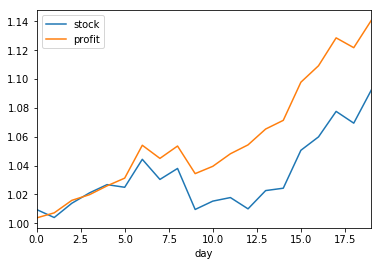

In [85]:
result_df[['day','stock','profit']].plot(x='day')

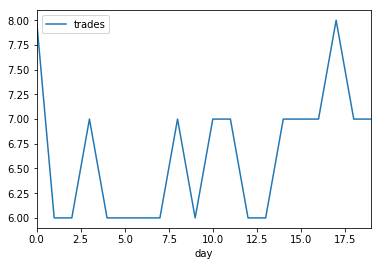

In [86]:
result_df[['day','trades']].plot(x='day')

In [77]:
 mixed_domain = [{'name': 'buy_threshold', 'type': 'continuous', 'domain': (0.0, 0.001)},
                 {'name': 'sell_threshold', 'type': 'continuous', 'domain': (-0.001, 0.0)},
                 {'name': 'min_hold_steps', 'type': 'discrete', 'domain': range(10,100)},
         ]
    

    
def opt_wrapper(X_list):
    print(X_list)
    buy_threshold = X_list[0][0]
    sell_threshold = X_list[0][1]
    min_hold_steps = int(X_list[0][2])
    tot_profit = 1
    tot_stock_profit = 1
    last_step = None
    for day_idx in range(len(my_df_list)):
        #print("starting day {}".format(day_idx))
        trades = 0
        daily_profit = 1
        state = 0
        df = my_df_list[day_idx]
        for step in range(len(df)):
            if df.iloc[step]['test_y'] > buy_threshold and state == 0:
                price = df.iloc[step]['last_20']
                #print("buy at step {} price:{}".format(step, price))
                state = 1
                last_step = step
            elif state == 1 and ((df.iloc[step]['test_y'] < buy_threshold and step - last_step > min_hold_steps) or step == len(df) - 1):
                last_price = price
                price = df.iloc[step]['last_20']
                #print("sell at step {} price:{}".format(step, price))
                profit = (price - last_price)/last_price
                tot_profit *= (1+profit)
                daily_profit *= (1 + profit)
                state = 0
                trades += 1
        last = df.iloc[len(df)-1].last_20
        open = df.iloc[0].last_20
        stock_profit = (last - open) / open
        tot_stock_profit *= (1+stock_profit)
        #print("finishing day {}, daily_profit:{}".format(day_idx, daily_profit))
    print("{}, profit:{}".format(X_list, tot_profit))
    return -tot_profit
    


In [78]:
myBopt = GPyOpt.methods.BayesianOptimization(opt_wrapper,  # Objective function       
                                     domain=mixed_domain,          # Box-constraints of the problem
                                     initial_design_numdata = 20,   # Number data initial design
                                     acquisition_type='EI',        # Expected Improvement
                                     exact_feval = True)           # True evaluations, no sample noise

myBopt.run_optimization(100,eps=0)

[[ 3.97572021e-04 -1.53338858e-04  7.90000000e+01]]
[[ 3.97572021e-04 -1.53338858e-04  7.90000000e+01]], profit:1.0662173245778943
[[ 5.17751351e-04 -1.43675708e-04  9.50000000e+01]]
[[ 5.17751351e-04 -1.43675708e-04  9.50000000e+01]], profit:1.0807390112600217
[[ 8.37710106e-04 -5.95491873e-04  2.00000000e+01]]
[[ 8.37710106e-04 -5.95491873e-04  2.00000000e+01]], profit:1.0433780517470976
[[ 6.75690117e-04 -1.12229901e-04  2.50000000e+01]]
[[ 6.75690117e-04 -1.12229901e-04  2.50000000e+01]], profit:1.0584913323632092
[[ 7.35216119e-04 -1.49071551e-04  8.20000000e+01]]
[[ 7.35216119e-04 -1.49071551e-04  8.20000000e+01]], profit:1.0377336264309218
[[ 2.09071621e-04 -6.43650058e-05  6.80000000e+01]]
[[ 2.09071621e-04 -6.43650058e-05  6.80000000e+01]], profit:1.0690427505176388
[[ 5.41447974e-04 -2.14659349e-04  7.90000000e+01]]
[[ 5.41447974e-04 -2.14659349e-04  7.90000000e+01]], profit:1.0576929804973267
[[ 6.95784399e-04 -3.31011745e-04  8.90000000e+01]]
[[ 6.95784399e-04 -3.31011745e-

[[ 1.28063172e-04 -7.83945639e-04  6.10000000e+01]]
[[ 1.28063172e-04 -7.83945639e-04  6.10000000e+01]], profit:1.1078826694011557
[[ 1.87640569e-05 -7.89578060e-04  8.00000000e+01]]
[[ 1.87640569e-05 -7.89578060e-04  8.00000000e+01]], profit:1.0885479104270925
[[ 1.71181643e-04 -4.35017875e-04  2.90000000e+01]]
[[ 1.71181643e-04 -4.35017875e-04  2.90000000e+01]], profit:1.0975180132262252
[[ 7.42767358e-05 -7.06917817e-04  6.10000000e+01]]
[[ 7.42767358e-05 -7.06917817e-04  6.10000000e+01]], profit:1.1309759756682105
[[ 1.25381594e-04 -6.97241440e-04  6.10000000e+01]]
[[ 1.25381594e-04 -6.97241440e-04  6.10000000e+01]], profit:1.1121233917054556
[[ 2.60405857e-04 -5.16668643e-04  2.90000000e+01]]
[[ 2.60405857e-04 -5.16668643e-04  2.90000000e+01]], profit:1.0988363530076797
[[ 8.70115882e-05 -7.43002466e-04  6.10000000e+01]]
[[ 8.70115882e-05 -7.43002466e-04  6.10000000e+01]], profit:1.143589869646238
[[ 8.37721260e-05 -5.27103247e-04  2.90000000e+01]]
[[ 8.37721260e-05 -5.27103247e-0

In [82]:
my_df[['test_y','valid_y']].corr()

,test_y,valid_y
test_y,1.000000,0.711176
valid_y,0.711176,1.000000


In [83]:
my_df['diff']=my_df['test_y']-my_df['valid_y']

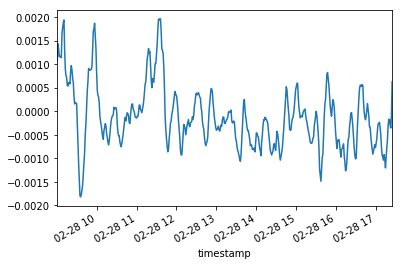

In [84]:
my_df['diff'].plot()

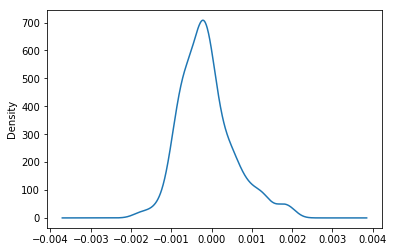

In [85]:
my_df['diff'].plot.kde()

In [86]:
my_df['diff'].mean()

-0.0001233379876338359

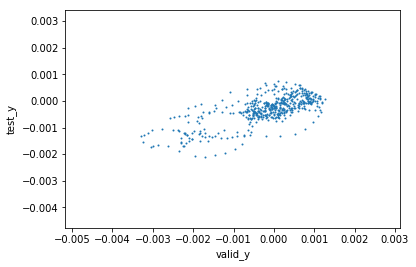

In [87]:
my_df.plot.scatter(x='valid_y', y='test_y',s=1)

In [88]:
my_df['diff'].max()

0.0019612595114189297

In [89]:
my_df.loc[my_df['valid_y'].argmax()]

last_20                    249.150000
value_ema_20_beta_98_20      0.001258
test_y                       0.000055
valid_y                      0.001258
diff                        -0.001203
Name: 2019-02-28 17:14:00+01:00, dtype: float64

In [90]:
my_df

,last_20,value_ema_20_beta_98_20,test_y,valid_y,diff
timestamp,,,,,
2019-02-28 09:01:00+01:00,252.20,-0.000660,0.000436,-0.000660,0.001096
2019-02-28 09:02:00+01:00,252.20,-0.001085,0.000346,-0.001085,0.001431
2019-02-28 09:03:00+01:00,251.75,-0.001291,0.000019,-0.001291,0.001310
2019-02-28 09:04:00+01:00,251.70,-0.001432,-0.000275,-0.001432,0.001157
2019-02-28 09:05:00+01:00,251.80,-0.001604,-0.000437,-0.001604,0.001168
2019-02-28 09:06:00+01:00,251.60,-0.001784,-0.000627,-0.001784,0.001157
2019-02-28 09:07:00+01:00,251.55,-0.001903,-0.000764,-0.001903,0.001138
2019-02-28 09:08:00+01:00,252.10,-0.002196,-0.000552,-0.002196,0.001645
2019-02-28 09:09:00+01:00,251.65,-0.002346,-0.000570,-0.002346,0.001775


In [91]:
buy_threshold = 0.0005
sell_threshold = -0.0005

action_steps = my_df[my_df['test_y']>0.0005].append(my_df[my_df['test_y']<-0.0005]).sort_values('timestamp')

In [92]:
state = 0
profit = 1
for i in range(len(my_df)):
    row = my_df.iloc[i]
    if row['test_y'] > 0.0001 and state == 0:
        print("buy at {} price:{}".format(row.index, row.last_20))
        state = 1
        price = row.last_20
    elif row['test_y'] < -0.0001 and state == 1:
        state = 0
        ratio = (row.last_20 - price) / price
        print("sell at {} price:{}".format(row.index, row.last_20)) 
        if ratio != 0:
            profit = profit * ratio
print("profit={}".format(profit))

buy at Index(['last_20', 'value_ema_20_beta_98_20', 'test_y', 'valid_y', 'diff'], dtype='object') price:252.2
sell at Index(['last_20', 'value_ema_20_beta_98_20', 'test_y', 'valid_y', 'diff'], dtype='object') price:251.7
buy at Index(['last_20', 'value_ema_20_beta_98_20', 'test_y', 'valid_y', 'diff'], dtype='object') price:250.8
sell at Index(['last_20', 'value_ema_20_beta_98_20', 'test_y', 'valid_y', 'diff'], dtype='object') price:250.55
buy at Index(['last_20', 'value_ema_20_beta_98_20', 'test_y', 'valid_y', 'diff'], dtype='object') price:249.95
sell at Index(['last_20', 'value_ema_20_beta_98_20', 'test_y', 'valid_y', 'diff'], dtype='object') price:249.7
buy at Index(['last_20', 'value_ema_20_beta_98_20', 'test_y', 'valid_y', 'diff'], dtype='object') price:247.55
sell at Index(['last_20', 'value_ema_20_beta_98_20', 'test_y', 'valid_y', 'diff'], dtype='object') price:247.35
buy at Index(['last_20', 'value_ema_20_beta_98_20', 'test_y', 'valid_y', 'diff'], dtype='object') price:247.8
se

In [69]:
action_steps

,last_20,value_ema_20_beta_98_20,test_y,valid_y,diff
timestamp,,,,,
2019-02-26 09:02:00+01:00,255.60,-0.000461,-0.000537,-0.000461,-0.000076
2019-02-26 09:09:00+01:00,255.45,-0.000057,-0.000570,-0.000057,-0.000513
2019-02-26 09:10:00+01:00,255.35,0.000170,-0.000696,0.000170,-0.000866
2019-02-26 09:11:00+01:00,255.35,0.000364,-0.000770,0.000364,-0.001135
2019-02-26 09:12:00+01:00,255.40,0.000603,-0.000773,0.000603,-0.001377
2019-02-26 09:13:00+01:00,255.40,0.000887,-0.000745,0.000887,-0.001632
2019-02-26 09:14:00+01:00,255.40,0.001151,-0.000699,0.001151,-0.001850
2019-02-26 09:23:00+01:00,256.40,0.000542,0.000507,0.000542,-0.000035
2019-02-26 09:24:00+01:00,256.40,0.000193,0.000623,0.000193,0.000430
